In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numpngw import write_apng
from IPython.display import Image
from pendulum import *
import mujoco
from lqr import *


  0%|          | 0/100 [00:00<?, ?it/s]

[ 0.         10.47197551  4.19873858  4.19873858]
[[4.0e+01 4.0e+01 4.0e+01]
 [2.0e-02 1.0e+00 0.0e+00]
 [1.0e-01 1.0e-01 0.0e+00]
 [4.5e-02 3.0e-01 0.0e+00]
 [4.5e-02 3.0e-01 0.0e+00]]
[[0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.3]
 [0.  0.  0.3]]
[[0.         0.         0.        ]
 [0.1267109  0.1267109  0.04817109]
 [0.15497067 0.15497067 0.00417393]
 [0.15497067 0.15497067 0.00417393]]
1
2
3
[0.05 0.05 0.05]
0.01
[ 1.00e-05  0.00e+00 -9.81e+00]
[[0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.6]]


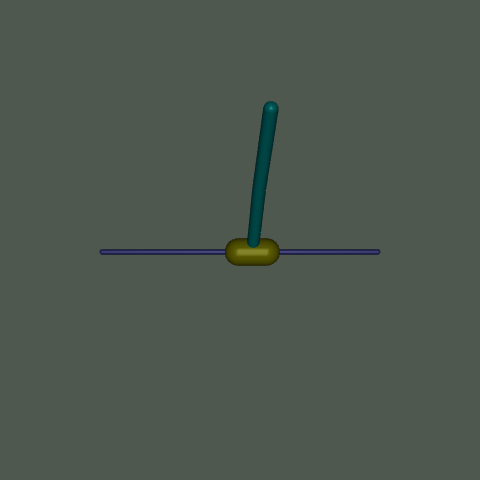

In [14]:
# Test environment
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
env.reset()

frames = []  # frames to create animated png
frames.append(env.render())
for i in tqdm(range(100)):
    action = env.action_space.sample()
    s = env.step(action)
    img = env.render()
    frames.append(img)

# Get properties of the pendulum
m = env.model.body_mass
l = env.model.geom_size
lcm = env.model.body_ipos
I = env.model.body_inertia
print(m)
print(l)
print(lcm)
print(I)

print(mujoco.mj_name2id(env.model, 1, 'cart'))
print(mujoco.mj_name2id(env.model, 1, 'pole'))
print(mujoco.mj_name2id(env.model, 1, 'pole2'))

print(env.model.dof_damping)
print(env.model.opt.timestep)
print(env.model.opt.gravity)
print(env.model.body_pos)

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")

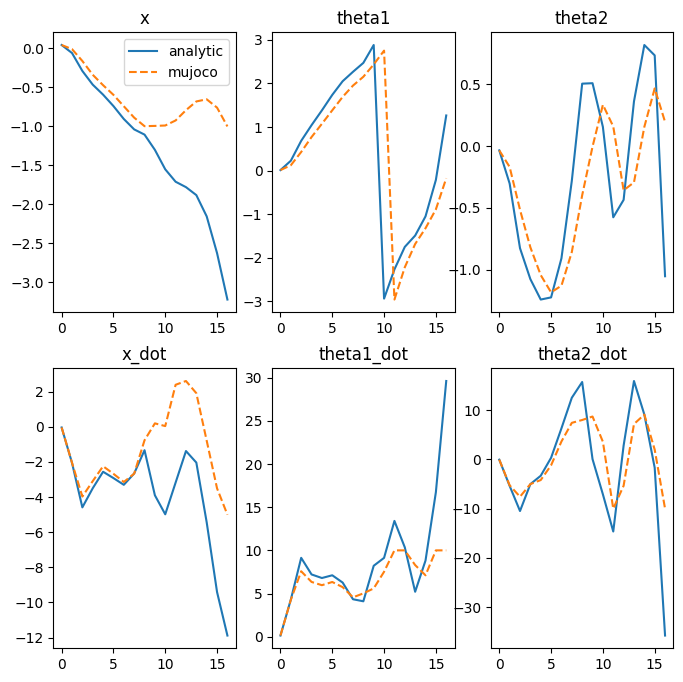

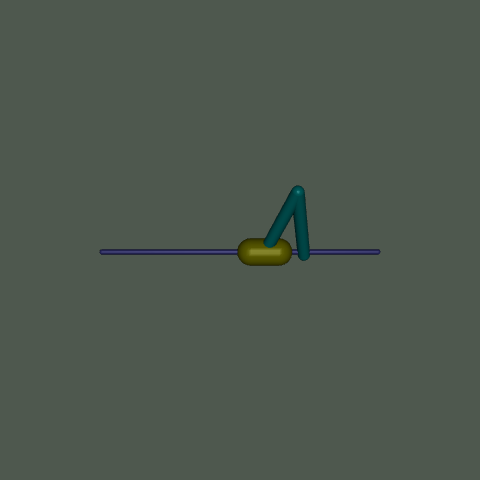

In [15]:
## Let's test to see if your analytic dynamics matches the simulator

frames = []  # frames to create animated png
frames.append(env.render())

# Total time steps
T = 16

# First let's generate a random control sequence
control_sequence = np.random.randn(T, 1)

# We use the simulator to simulate a trajectory
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
start_state, _ = env.reset()

states_mujoco = np.zeros((T+1, 8))
states_mujoco[0] = start_state[:8]

for t in range(T):
    full_states_mujoco, _, _, _, _ = env.step(control_sequence[t])
    states_mujoco[t+1] = full_states_mujoco[:8]
    img = env.render()
    frames.append(img)

# Now we will use your analytic dynamics to simulate a trajectory
# Need an extra 1 which is the batch dimension (T x B x 4)
states_analytic = torch.zeros((T+1, 1, 6))
states_analytic[0] = change_of_coords(start_state)
for t in range(T):
    states_analytic[t + 1] = dynamics_analytic(states_analytic[t], torch.from_numpy(control_sequence[t]))

# convert back to numpy for plotting
states_analytic = states_analytic.reshape(T+1, 6)

# convert mujoco states to analytic states
states_mujoco_transformed = T_change_of_coords(states_mujoco)

# Plot and compare - They should be indistinguishable
fig, axes = plt.subplots(2, 3, figsize=(8, 8))

axes[0][0].plot(states_analytic[:, 0], label='analytic')
axes[0][0].plot(states_mujoco_transformed[:, 0], '--', label='mujoco')
axes[0][0].title.set_text('x')

axes[0][1].plot(states_analytic[:, 1])
axes[0][1].plot(states_mujoco_transformed[:, 1], '--')
axes[0][1].title.set_text('theta1')

axes[0][2].plot(states_analytic[:, 2])
axes[0][2].plot(states_mujoco_transformed[:, 2], '--')
axes[0][2].title.set_text('theta2')

axes[1][0].plot(states_analytic[:, 3])
axes[1][0].plot(states_mujoco_transformed[:, 3], '--')
axes[1][0].title.set_text('x_dot')

axes[1][1].plot(states_analytic[:, 4])
axes[1][1].plot(states_mujoco_transformed[:, 4], '--')
axes[1][1].title.set_text('theta1_dot')

axes[1][2].plot(states_analytic[:, 5])
axes[1][2].plot(states_mujoco_transformed[:, 5], '--')
axes[1][2].title.set_text('theta2_dot')

axes[0][0].legend()
plt.show()

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")


In [49]:
# simulation parameters
Tf = 0.5 # this refers to the time horizon for the optimization
dt = 0.05
N = int(Tf/dt + 1)
num_lqr_iterations = 4
mu_min = 10e-6
mu = mu_min
mu_delta_0 = 2
mu_delta = mu_delta_0
num_mpc_iterations = 100

# LQR parameters
# set the desired state (xstar), should be the goal state
# will will be linearizing about this point
xstar = torch.zeros((6,))
# set the Q and R matrices
# TODO: tune the Q, R amd Qf matrices
Q = torch.diag(torch.tensor([0.5, 1.0, 2.0, 0.5, 0.5, 0.5]))
R = 0.5*torch.tensor([1])
Qf = 1000 * torch.eye(6)

  0%|          | 0/100 [00:00<?, ?it/s]

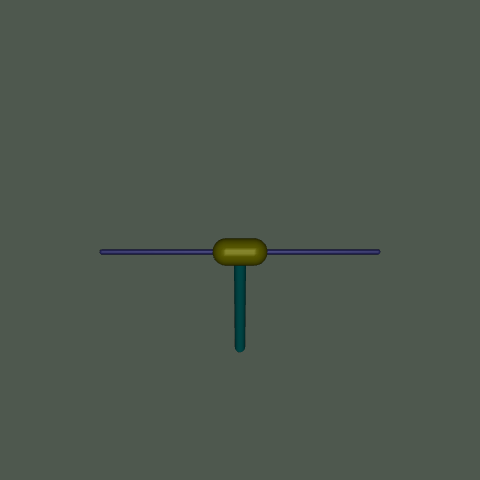

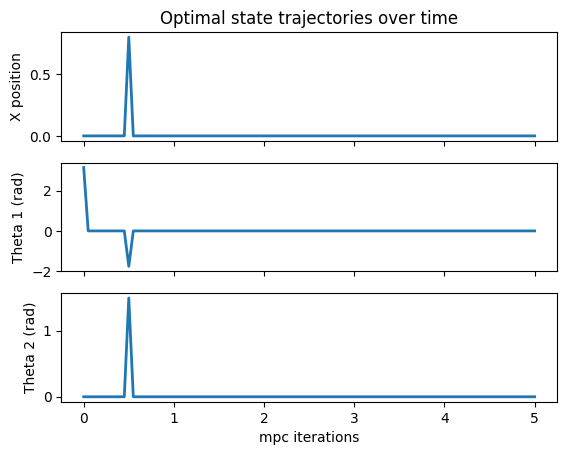

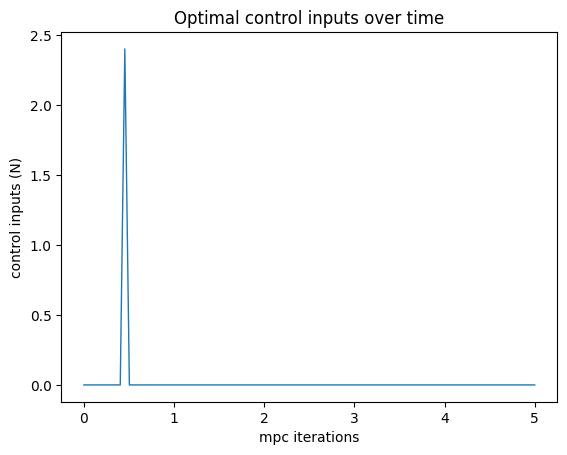

In [50]:
## run MPC on the simulated double inverted pendulum
# initialize the inverted pedulum object
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
# get the initial state of the simulation
# start_state,_ = env.reset()
pos = [0, np.pi, 0]
vel = [0, 0, 0]
acc = [0, 0, 0]
start_state = set_state(env, pos, vel, acc)
#init_state = start_state[:8].reshape(8,)
#current_state = change_of_coords(init_state)
current_state = change_of_coords(start_state)
_,_,_,_,_ = env.step(np.array([0]))

# store all of the actions over all the iterations of LQR
actions = torch.zeros((num_mpc_iterations, 1))
states = torch.zeros((num_mpc_iterations+1, 6))
states[0, :] = current_state

frames = []  # frames to create animated png
frames.append(env.render())
for i in tqdm(range(num_mpc_iterations)):
    # get the current state
    # current_state = get_state(env)
    #current_state = current_state[:8].reshape(8,1)
    # run the iLQR optimization
    us, _ = run_ilqr(current_state, N, Tf, num_lqr_iterations, xstar, mu, mu_delta_0, mu_delta, mu_min, Q, R)
    # get the first control input value from the ilqr optimization
    action = us[0,:]
    # apply the action to move the simulation to the next state
    next_state,_,_,_,_ = env.step(action)
    next_state = change_of_coords(next_state)
    img = env.render()
    frames.append(img)
    # store all of the actions and the states that were taken
    actions[t, :] = action
    states[t+1, :] = next_state
    current_state = next_state

# plot the optimal state trajectory over time
t_vec_x = np.linspace(0, dt*num_mpc_iterations, num_mpc_iterations+1)
fig, axs = plt.subplots(3,1,sharex=True)
lin0, = axs[0].plot(t_vec_x, states[:,0], lw=2) 
lin1, = axs[1].plot(t_vec_x, states[:,1], lw=2)
lin2, = axs[2].plot(t_vec_x, states[:,2], lw=2)
axs[0].set_title('Optimal state trajectories over time')
axs[0].set_ylabel("X position")
axs[1].set_ylabel("Theta 1 (rad)")
axs[2].set_ylabel("Theta 2 (rad)")
axs[-1].set_xlabel("mpc iterations")  

# plot the optimal control trajectory
plt.figure()
t_vec_u = np.linspace(0,dt*num_mpc_iterations,num_mpc_iterations)
lin0, = plt.plot(t_vec_u, actions[:,0], lw=1)
plt.title('Optimal control inputs over time')
plt.ylabel("control inputs (N)")
plt.xlabel("mpc iterations")

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")